In [24]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Training Model

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [26]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [27]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [28]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [29]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [30]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

In [31]:
len(y_val)

1409

In [32]:
thresholds=np.linspace(0,1,21)
scores=[]
for t in thresholds:
    churn_decision=(y_pred>=t)
    score=(y_val==churn_decision).mean()
    print('%.2f %.3f' % (t,score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


0.5 gives the highest score

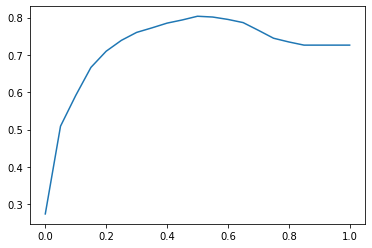

In [33]:
plt.plot(thresholds,scores)

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val,y_pred>=0.5)

0.8034066713981547

In [35]:
thresholds=np.linspace(0,1,21)
scores=[]
for t in thresholds:
    score=accuracy_score(y_val,y_pred>=t)
    print('%.2f %.3f' % (t,score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [36]:
from collections import Counter
Counter(y_pred>=1.0)

Counter({False: 1409})

In [37]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [38]:
1-y_val.mean()

0.7260468417317246

## Confusion Table

In [39]:
actual_positive=(y_val==1)
actual_negative=(y_val==0)

In [40]:
t=0.5
predict_positive=(y_pred>=t)
predict_negative=(y_pred<t)

In [41]:
tp=(predict_positive & actual_positive).sum()
tn=(predict_negative & actual_negative).sum()

In [42]:
fp=(predict_positive & actual_negative).sum()
fn=(predict_negative & actual_positive).sum()

In [43]:
print(tp,tn,fp,fn)

210 922 101 176


In [44]:
confusion_matrix=np.array([[
    tn,fp],
    [fn,tp]
])
confusion_matrix/confusion_matrix.sum()

array([[0.6543648 , 0.07168204],
       [0.12491128, 0.14904187]])

Accuracy rate=80%=0.65+0.15

## Precision and Recall: accuracy can be misleading

Precision:(fail to detect)

In [45]:
p=tp/(tp+fp)

In [46]:
print(p)

0.6752411575562701


Recall:(fail to identify)

In [49]:
r=tp/(tp+fn)

In [50]:
print(r)

0.5440414507772021


## ROC curves

In [51]:
fpr=fp/(tn+fp)

In [52]:
tpr=tp/(fn+tp)

In [53]:
print(fpr,tpr)

0.09872922776148582 0.5440414507772021


In [55]:
scores=[]
thresholds=np.linspace(0,1,101)
for t in thresholds:
    actual_positive=(y_val==1)
    actual_negative=(y_val==0)
    
    predict_positive=(y_pred>=t)
    predict_negative=(y_pred<t)
    
    tp=(predict_positive&actual_positive).sum()
    tn=(predict_negative&actual_negative).sum()
    fp=(predict_positive&actual_negative).sum()
    fn=(predict_negative&actual_positive).sum()
    
    scores.append((t,tp,fp,fn,tn))

In [64]:
columns=['thresholds','tp','fp','fn','tn']
df_scores=pd.DataFrame(scores,columns=columns)

In [65]:
df_scores['tpr']=df_scores.tp/(df_scores.fn+df_scores.tp)
df_scores['fpr']=df_scores.fp/(df_scores.tn+df_scores.fp)

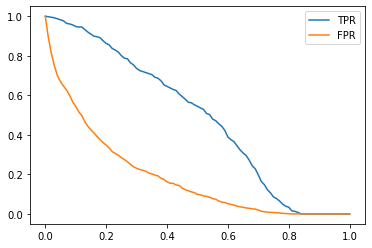

In [66]:
plt.plot(df_scores.thresholds,df_scores['tpr'],label='TPR')
plt.plot(df_scores.thresholds,df_scores['fpr'],label='FPR')
plt.legend()

## Random model

In [68]:
np.random.seed(1)
y_rand=np.random.uniform(0,1,size=len(y_val))

In [69]:
((y_rand>=0.5)==y_val).mean()

0.5017743080198722

In [70]:
def tpr_fpr_dataframe(y_val,y_pred):
    scores=[]
    thresholds=np.linspace(0,1,101)
    for t in thresholds:
        actual_positive=(y_val==1)
        actual_negative=(y_val==0)

        predict_positive=(y_pred>=t)
        predict_negative=(y_pred<t)

        tp=(predict_positive&actual_positive).sum()
        tn=(predict_negative&actual_negative).sum()
        fp=(predict_positive&actual_negative).sum()
        fn=(predict_negative&actual_positive).sum()

        scores.append((t,tp,fp,fn,tn))
    columns=['thresholds','tp','fp','fn','tn']
    df_scores=pd.DataFrame(scores,columns=columns)
    df_scores['tpr']=df_scores.tp/(df_scores.fn+df_scores.tp)
    df_scores['fpr']=df_scores.fp/(df_scores.tn+df_scores.fp)
    return df_scores

In [71]:
df_rand=tpr_fpr_dataframe(y_val,y_rand)

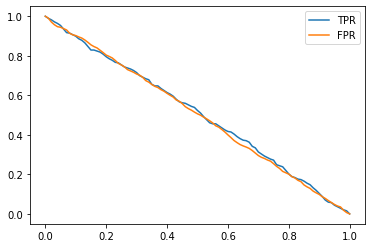

In [76]:
plt.plot(df_rand.thresholds,df_rand['tpr'],label='TPR')
plt.plot(df_rand.thresholds,df_rand['fpr'],label='FPR')
plt.legend()

## ideal model

In [78]:
num_neg=(y_val==0).sum()
num_pos=(y_val==1).sum()
num_neg,num_pos

(1023, 386)

In [80]:
y_ideal=np.repeat([0,1],[num_neg,num_pos])

In [81]:
y_ideal_pred=np.linspace(0,1,len(y_val))

In [82]:
1-y_val.mean()

0.7260468417317246

In [83]:
((y_ideal_pred>=0.726)==y_ideal).mean()

1.0

In [84]:
df_ideal=tpr_fpr_dataframe(y_ideal,y_ideal_pred)

In [100]:
df_ideal

,thresholds,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,386,1008,0,15,1.000000,0.985337
2,0.02,386,994,0,29,1.000000,0.971652
3,0.03,386,980,0,43,1.000000,0.957967
4,0.04,386,966,0,57,1.000000,0.944282
...,...,...,...,...,...,...,...
96,0.96,57,0,329,1023,0.147668,0.000000
97,0.97,43,0,343,1023,0.111399,0.000000
98,0.98,29,0,357,1023,0.075130,0.000000
99,0.99,15,0,371,1023,0.038860,0.000000


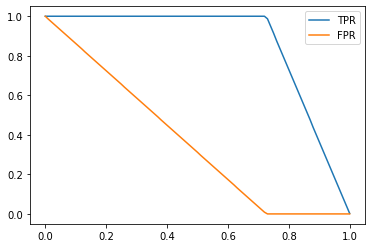

In [86]:
plt.plot(df_ideal.thresholds,df_ideal['tpr'],label='TPR')
plt.plot(df_ideal.thresholds,df_ideal['fpr'],label='FPR')
plt.legend()

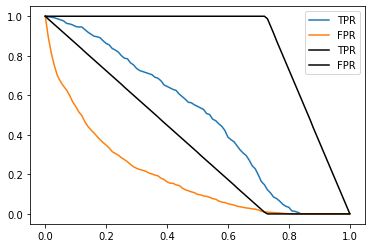

In [89]:
plt.plot(df_scores.thresholds,df_scores['tpr'],label='TPR')
plt.plot(df_scores.thresholds,df_scores['fpr'],label='FPR')

# plt.plot(df_rand.thresholds,df_rand['tpr'],label='TPR')
# plt.plot(df_rand.thresholds,df_rand['fpr'],label='FPR')

plt.plot(df_ideal.thresholds,df_ideal['tpr'],label='TPR',color='black')
plt.plot(df_ideal.thresholds,df_ideal['fpr'],label='FPR',color='black')

plt.legend()


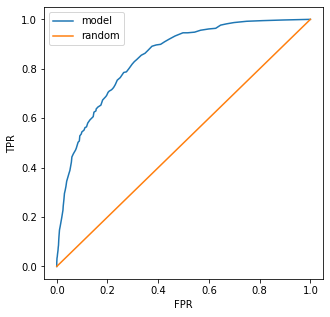

In [93]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr,df_scores.tpr,label='model')
plt.plot([0,1],[0,1],label='random')
#plt.plot(df_rand.fpr,df_rand.tpr,label='random')
#plt.plot(df_ideal.fpr,df_ideal.tpr,label='ideal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [103]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_val,y_pred)

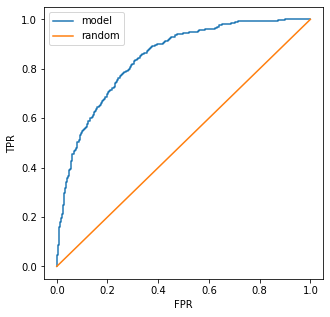

In [104]:
plt.figure(figsize=(5,5))

plt.plot(fpr,tpr,label='model')
plt.plot([0,1],[0,1],label='random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

## AUC: Area under the curve

In [105]:
from sklearn.metrics import auc
auc(fpr,tpr)

0.843850505725819

In [106]:
auc(df_scores.fpr,df_scores.tpr)

0.8438732975754537

In [107]:
auc(df_ideal.fpr,df_ideal.tpr)

0.9999430203759136

In [108]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val,y_pred)

0.843850505725819

In [115]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [132]:
dv, model = train(df_train, y_train, C=10)

In [133]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [134]:
y_pred = predict(df_val, dv, model)

In [135]:
from sklearn.model_selection import KFold
kfold=KFold(n_splits=10,shuffle=True,random_state=1)

In [136]:
scores=[]

for train_idx,val_idx in kfold.split(df_full_train):
    df_train=df_full_train.iloc[train_idx]
    df_val=df_full_train.iloc[val_idx]
    
    y_train=df_train.churn.values
    y_val=df_val.churn.values
    
    dv,model=train(df_train,y_train)
    y_pred=predict(df_val,dv,model)
    
    auc=roc_auc_score(y_val,y_pred)
    scores.append(auc)

In [137]:
len(train_idx),len(val_idx)

(5071, 563)

In [139]:
from tqdm.auto import tqdm

In [131]:
print('%.3f +- %.3f'%(np.mean(scores),np.std(scores)))

0.840 +- 0.013


In [140]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.841 +- 0.006
C=1 0.841 +- 0.007
C=5 0.842 +- 0.008
C=10 0.842 +- 0.008

